In [29]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


### 광고시설물 유형별 면적 기준 (정성기획, 연수구청)

| 광고시설물명               | 광고 유형         | 평균 크기 (mm)        | 면적 (m제곱) | 출처     |
|----------------------------|-------------------|------------------------|-----------|----------|
| DID                        | 디지털 패널       | 1,920 × 1,080          | 2.07      | 정성기획 |
| 가로기                     | 배너형 광고        | 600 × 1,800            | 1.08      | 연수구청 |
| 기둥사이벽면               | 고정 벽면 광고     | 2,000 × 3,000          | 6.00      | 정성기획 |
| 대형 벽면                  | 대형 벽면 광고     | 5,000 × 10,000         | 50.00     | 정성기획 |
| 벽면                       | 고정 벽면 광고     | 2,000 × 3,000          | 6.00      | 정성기획 |
| 벽면(DID)                  | 디지털 패널       | 1,920 × 1,080          | 2.07      | 정성기획 |
| 벽면/DID                   | 디지털 패널       | 1,920 × 1,080          | 2.07      | 정성기획 |
| 벽면/DID/스크린도어        | 디지털 패널       | 1,920 × 1,080          | 2.07      | 정성기획 |
| 스크린도어                 | 스크린도어 광고    | 2,000 × 1,300          | 2.60      | 정성기획 |
| 스크린도어(DID)           | 디지털 패널       | 1,920 × 1,080          | 2.07      | 정성기획 |
| 승강장 안전문              | 스크린도어 광고    | 2,000 × 1,300          | 2.60      | 정성기획 |
| 승강장 안전문/스크린도어   | 스크린도어 광고    | 2,000 × 1,300          | 2.60      | 정성기획 |
| 승강장안전문               | 스크린도어 광고    | 2,000 × 1,300          | 2.60      | 정성기획 |
| 유리벽면                   | 고정 벽면 광고     | 2,000 × 3,000          | 6.00      | 정성기획 |
| 전동차내부                 | 차량 내부 광고     | 400 × 900              | 0.36      | 정성기획 |
| 정류소                     | 지상 광고          | 1,200 × 1,800          | 2.16      | 연수구청 |
| 조명박스                   | 조명형 광고        | 1,200 × 1,800          | 2.16      | 정성기획 |
| 조명박스/DID               | 디지털 패널       | 1,920 × 1,080          | 2.07      | 정성기획 |
| 지하도                     | 고정 벽면 광고     | 2,000 × 3,000          | 6.00      | 정성기획 |
| 청사내                     | 고정 벽면 광고     | 2,000 × 3,000          | 6.00      | 정성기획 |



### 광고시설물명별 광고유형 및 면적 추론 기준 

| 광고시설물명                     | 매핑된 광고 유형     | 추론 근거 키워드                     | 추론 면적 (m²) |
|----------------------------------|------------------------|---------------------------------------|----------------|
| 공간활용 프로모션               | 대형 벽면 광고         | 프로모션 = 대형 벽면 활용            | 50.00          |
| 기둥조명                         | 조명형 광고            | 조명, 기둥 = 조명박스                | 2.16           |
| 디지털보드                       | 디지털 패널            | DID 계열                              | 2.07           |
| 디지털종합안내도_디지털          | 디지털 패널            | DID 계열                              | 2.07           |
| 디지털종합안내도_인쇄식          | 고정 벽면 광고         | 안내도 + 인쇄 = 벽면                 | 6.00           |
| 디지털종합안내도_조명            | 조명형 광고            | 안내도 + 조명                         | 2.16           |
| 디지털포스터                     | 디지털 패널            | DID 계열                              | 2.07           |
| 멀티비젼                         | 디지털 패널            | 멀티비전 = DID 계열                  | 2.07           |
| 스마트 정보 안내시스템          | 디지털 패널            | 스마트 + 정보 + DID                  | 2.07           |
| 승강장매립형                     | 고정 벽면 광고         | 매립형 벽면                           | 6.00           |
| 승강장안전문 광고(민자)_난간형   | 스크린도어 광고        | 승강장안전문                          | 2.60           |
| 승강장안전문 광고(민자)_동영상   | 디지털 패널            | 동영상 = DID 계열                    | 2.07           |
| 승강장안전문 광고(민자)_일반형   | 스크린도어 광고        | 일반형 = 스크린도어                  | 2.60           |
| 승강장안전문 조명(민자제외)      | 스크린도어 광고        | 조명 + 안전문                        | 2.60           |
| 승강장음성광고                   | 비시각 매체 (면적 0 처리) | 음성 전용, 면적 없음                | 0.00           |
| 역구내조명광고                   | 조명형 광고            | 조명 광고                             | 2.16           |
| 역구내포스터                     | 고정 벽면 광고         | 포스터 = 벽면                         | 6.00           |
| 역구내행선안내게시기             | 디지털 패널            | 안내 + 디지털 기능                    | 2.07           |
| 제2기 교통카드 RF단말기 광고     | 디지털 패널            | 단말기 = 디지털 기기                 | 2.07           |
| 지하철 출입구 상단벽면           | 고정 벽면 광고         | 벽면 키워드                           | 6.00           |


In [3]:
# CSV 파일 불러오기
df = pd.read_csv('ad_info.csv', encoding='euc-kr')

# 광고시설물명에 따라 면적 매핑 
area_mapping = {
    '공간활용 프로모션': 50.00,
    '기둥조명': 2.16,
    '디지털보드': 2.07,
    '디지털종합안내도_디지털': 2.07,
    '디지털종합안내도_인쇄식': 6.00,
    '디지털종합안내도_조명': 2.16,
    '디지털포스터': 2.07,
    '멀티비젼': 2.07,
    '스마트 정보 안내시스템': 2.07,
    '역구내조명광고': 2.16,
    '역구내포스터': 6.00,
    '역구내행선안내게시기': 2.07,
    '제2기 교통카드 RF단말기 광고': 2.07,
    '지하철 출입구 상단벽면': 6.00,
}

area_mapping2 = {
    '승강장매립형': 6.00,
    '승강장안전문 광고(민자)_난간형': 2.60,
    '승강장안전문 광고(민자)_동영상': 2.07,
    '승강장안전문 광고(민자)_일반형': 2.60,
    '승강장안전문 조명(민자제외)': 2.60,
    '승강장음성광고': 0.00,
}
# 광고시설물 면적 컬럼 생성

df['면적'] = df['광고시설물명'].map(area_mapping).fillna(0.00).round(2)
df['승강장면적'] = df['광고시설물명'].map(area_mapping2).fillna(0.00).round(2)

df.drop(columns=['호선', '연번', '역번호', '광고대행사', '데이터기준일자'], errors='ignore', inplace=True)

# 면적 추가된 결과 저장
df.to_csv('ad_facility_with_area.csv', index=False, encoding='euc-kr')


In [4]:
# 데이터 불러오기
df = pd.read_csv('ad_facility_with_area.csv', encoding='euc-kr')

# 사용면적 계산
df['대합실사용면적'] = df['면적'] * df['광고시설물 수량']
df['승강장사용면적'] = df['승강장면적'] * df['광고시설물 수량']

# 불필요한 칼럼 삭제
df.drop(columns=['광고시설물명', '광고시설물 수량'], inplace=True)

# 역명 기준으로 사용면적 합산 (리스트로 다중 컬럼 지정)
df_grouped = df.groupby('역명', as_index=False)[['대합실사용면적', '승강장사용면적']].sum()

# 저장
df_grouped.to_csv('ad_usage_area_by_station.csv', index=False, encoding='euc-kr')



In [5]:
# 광고 데이터 불러오기
ad_raw = pd.read_csv('ad_usage_area_by_station.csv', encoding='euc-kr')
ad_raw.columns = ad_raw.columns.str.strip()

# 역명 괄호 제거 대상 리스트
rename_list = [
    "까치산(5)", "가산디지털단지(7)", "강남(2)", "김포공항(5)", "당산(2)", "도봉산(7)", "동작(4)", "디지털미디어시티(6)",
    "석촌(8)", "수서(3)", "신길(5)", "신도림(2)", "옥수(3)", "온수(7)", "올림픽공원(5)", "이수(7)",
    "종합운동장(2)", "창동(4)", "청량리(1)", "총신대입구(4)", "홍대입구(2)", "효창공원앞(6)"
]
# 괄호 제거 처리
ad_raw["역명"] = ad_raw["역명"].replace({x: x.split('(')[0] for x in rename_list})

# 연신내 평균 처리
yeonsinnae_rows = ad_raw[ad_raw["역명"].isin(["연신내(3)", "연신내(6)"])]
if not yeonsinnae_rows.empty:
    mean_row = yeonsinnae_rows.mean(numeric_only=True)
    # 기존 연신내(3)와 연신내(6) 삭제
    ad_raw = ad_raw[~ad_raw["역명"].isin(["연신내(3)", "연신내(6)"])]
    # 평균 값으로 새로운 연신내 행 추가
    new_row = pd.DataFrame([{"역명": "연신내", **mean_row.to_dict()}])
    ad_raw = pd.concat([ad_raw, new_row], ignore_index=True)

# 충무로 평균 처리
chungmuro_rows = ad_raw[ad_raw["역명"].isin(["충무로(3)", "충무로(4)"])]
if not chungmuro_rows.empty:
    mean_row = chungmuro_rows.mean(numeric_only=True)
    # 기존 충무로(3)와 충무로(4) 삭제
    ad_raw = ad_raw[~ad_raw["역명"].isin(["충무로(3)", "충무로(4)"])]
    # 평균 값으로 새로운 충무로 행 추가
    new_row = pd.DataFrame([{"역명": "충무로", **mean_row.to_dict()}])
    ad_raw = pd.concat([ad_raw, new_row], ignore_index=True)

# 정제된 광고 데이터를 CSV로 저장
ad_raw.to_csv('ad_raw.csv', index=False, encoding='euc-kr')


In [6]:
# CSV 파일 불러오기
df = pd.read_csv('passenger_info.csv', encoding='euc-kr')

# 날짜 및 연번 제거 후 집계
df_grouped = (
    df.drop(columns=['연번', '날짜'])
      .groupby(['호선', '역번호', '역명', '승객유형'], as_index=False)
      .agg({'승차인원': 'sum', '환승유입인원': 'sum'})
)

# 새 이름으로 저장
df_grouped.to_csv('Passenger_step1.csv', index=False, encoding='euc-kr')

In [7]:
#  CSV 파일 불러오기
df = pd.read_csv('Passenger_step1.csv', encoding='euc-kr')

# 유동인구 계산 (승차인원 + 환승유입인원)
df['유동인구'] = df['승차인원'] + df['환승유입인원']

# '공통' 유형 제거
df = df[df['승객유형'] != '공통']

# 통합 기준 정의
foreign_types = [
    '영어 어린이', '영어 일반',
    '일어 어린이', '일어 일반',
    '중국어 어린이', '중국어 일반',
    '외국인 경로'
]
minor_types = ['어린이', '중고생', '청소년']

# 유형 통합 함수 적용
def unify_type(x):
    if x in foreign_types:
        return '외국인'
    elif x in minor_types:
        return '미성년자'
    else:
        return x

df['승객유형'] = df['승객유형'].apply(unify_type)

# 통합된 승객유형 기준으로 재집계
df_grouped = (
    df.groupby(['호선', '역번호', '역명', '승객유형'], as_index=False)
      .agg({'승차인원': 'sum', '환승유입인원': 'sum', '유동인구': 'sum'})
)

# 첫 번째 피벗: 총인원 기준
df_pivot_총인원 = df_grouped.pivot_table(
    index=['호선', '역번호', '역명'],  # 역 기준
    columns='승객유형',               # 각 승객유형이 열로
    values='유동인구',                # 유동인구 값 (총인원)
    aggfunc='sum',                    # 중복 있는 경우 합산
    fill_value=0                      # 없는 경우는 0으로
).reset_index()

# 두 번째 피벗: 환승유입인원 기준
df_pivot_환승 = df_grouped.pivot_table(
    index=['호선', '역번호', '역명'],  # 역 기준
    columns='승객유형',               # 각 승객유형이 열로
    values='환승유입인원',            # 환승유입인원 값
    aggfunc='sum',                    # 중복 있는 경우 합산
    fill_value=0                      # 없는 경우는 0으로
).reset_index()

# 두 피벗 테이블을 병합

df_combined = pd.merge(df_pivot_총인원, df_pivot_환승, on=['호선', '역번호', '역명'], suffixes=('_총인원', '_환승'))

# 불필요한 열 제거
df_combined = df_combined.drop(columns=['다자녀부모_총인원', '생활보호자_총인원', '다자녀부모_환승', '생활보호자_환승','역번호', '국가유공자_총인원', '국가유공자_환승'], errors='ignore')

df = df_combined

# '경로' → '우대권', '직원' → '일반' 으로 통합
df['우대권_총인원'] = df.get('우대권_총인원', 0) + df.get('경로_총인원', 0)
if '경로_총인원' in df.columns:
    df.drop(columns='경로_총인원', inplace=True)

df['우대권_환승'] = df.get('우대권_환승', 0) + df.get('경로_환승', 0)
if '경로_환승' in df.columns:
    df.drop(columns='경로_환승', inplace=True)

df['일반_총인원'] = df.get('일반_총인원', 0) + df.get('직원_총인원', 0)
if '직원_총인원' in df.columns:
    df.drop(columns='직원_총인원', inplace=True)
    
df['일반_환승'] = df.get('일반_환승', 0) + df.get('직원_환승', 0)
if '직원_환승' in df.columns:
    df.drop(columns='직원_환승', inplace=True)
    
# 총인원과 총환승인원 컬럼생성
total_cols = ['미성년자_총인원', '일반_총인원', '우대권_총인원', '외국인_총인원', '장애인_총인원']  # 남아있는 유효 칼럼만 지정
df['총인원'] = df[total_cols].sum(axis=1)

total_cols = ['미성년자_환승', '일반_환승', '우대권_환승', '외국인_환승', '장애인_환승']  # 남아있는 유효 칼럼만 지정
df['총환승인원'] = df[total_cols].sum(axis=1)

# 비율 계산
df['외국인비율'] = (df['외국인_총인원'] / df['총인원'] * 100).round(2)
df['장애인비율'] = (df['장애인_총인원'] / df['총인원'] * 100).round(2)
df['환승비율'] = (df['총환승인원'] / df['총인원'] * 100).round(2)

# 외국인, 장애인, 환승관련 칼럼 제거
df.drop(columns=['외국인_총인원', '장애인_총인원', '미성년자_환승', '일반_환승', '우대권_환승', '외국인_환승', '장애인_환승'], inplace=True)

# 결과를 하나의 파일로 저장
df_combined.to_csv('Passenger2_step2.csv', index=False, encoding='euc-kr')


In [8]:
df = pd.read_csv('Passenger2_step2.csv', encoding='euc-kr')

desired_columns = [
    '호선', '역명', '총인원','환승비율', '일반_총인원', '우대권_총인원','미성년자_총인원', '외국인비율', '장애인비율'
]

# 열 순서 재배열
df = df[desired_columns]

# 괄호 및 괄호 안 내용 제거 함수 정의
def clean_station_name(name):
    if pd.isna(name):
        return name
    return re.sub(r'\([^)]*\)', '', name).strip()

# 역명 정제 적용
df['역명'] = df['역명'].apply(clean_station_name)

# 중복된 역명 확인
duplicated_names = df[df.duplicated(['역명'], keep=False)]

# 호선 번호에서 숫자만 추출
def extract_line_number(line):
    match = re.search(r'\d+', line)
    return match.group() if match else ''

# 중복된 역명에만 (호선번호) 추가
def rename_station(row):
    if (duplicated_names['역명'] == row['역명']).any():
        line_number = extract_line_number(row['호선'])
        return f"{row['역명']}({line_number})"
    else:
        return row['역명']

df['역명'] = df.apply(rename_station, axis=1)

# 호선별 광고단가 직접 지정
line_price = {
    '1': 30,
    '2': 40,
    '3': 35,
    '4': 30,
    '5': 30,
    '6': 22,
    '7': 30,
    '8': 30
}

# 호선번호 추출 ('1호선' → '1')
df['호선번호'] = df['호선'].str.extract(r'(\d+)')

# 광고단가 매핑
df['광고단가'] = df['호선번호'].map(line_price)

df.drop(columns=['호선', '호선번호'], inplace=True)

df.to_csv('Passenger_raw.csv', index=False, encoding='euc-kr')

In [9]:
# 파일 불러오기
df = pd.read_csv('station_area_info.csv', encoding='euc-kr')

# 연번 칼럼 제거
df = df.drop(columns=['연번'])

# 중복된 역명 확인
duplicated_names = df[df.duplicated('역명', keep=False)]

# 호선에서 숫자만 추출하는 함수 (예: '3호선' → '3')
def extract_line_number(line):
    line_str = str(line)  # 형변환 추가
    match = re.search(r'\d+', line_str)
    return match.group() if match else ''

# 중복 역명에 대해 괄호 붙이기
def rename_station(row):
    if (duplicated_names['역명'] == row['역명']).any():
        line_number = extract_line_number(row['호선'])
        return f"{row['역명']}({line_number})"
    else:
        return row['역명']

# 적용
df['역명'] = df.apply(rename_station, axis=1)

# 호선 제거
df.drop(columns=['호선'], errors='ignore', inplace=True)

# 저장
df.to_csv('station_area_info_cleaned.csv', index=False, encoding='euc-kr')


In [10]:
# 파일 불러오기
df = pd.read_csv('transfer_time_info.csv', encoding='euc-kr')

# 연번 컬럼 삭제
df.drop(columns=['연번'], inplace=True)

# 환승노선이 1~8호선인 행만 남기기
# 예: '2호선', '3호선' 등만 허용
allowed_lines = [f'{i}호선' for i in range(1, 9)]

# 환승노선이 1~8호선 모두인 경우만 필터링
def is_valid_transfer(transfer):
    # 환승노선이 쉼표로 구분되어 있을 수 있음
    lines = [line.strip() for line in str(transfer).split(',')]
    return all(line in allowed_lines for line in lines)

df = df[df['환승노선'].apply(is_valid_transfer)]

# 결과 저장 (선택)
df.to_csv('transfer_time_filtered.csv', index=False, encoding='euc-kr')


In [11]:
# 데이터 불러오기
df = pd.read_csv('transfer_time_filtered.csv', encoding='euc-kr')

# 원하는 열 순서 지정
desired_columns = [
    '환승역명', '호선', '환승노선', '환승거리', '환승소요시간'
]

# 열 순서 재배열
df = df[desired_columns]

# 복제할 행 리스트 초기화
augmented_rows = []

# 각 행 순회하면서 복제 행 생성
for _, row in df.iterrows():
    # 기존 행 유지
    augmented_rows.append(row)
    
    # 호선에서 숫자 추출
    line_number = ''.join(filter(str.isdigit, str(row['호선'])))
    
    # 괄호 포함 이름 생성
    new_row = row.copy()
    new_row['환승역명'] = f"{row['환승역명']}({line_number})"
    
    augmented_rows.append(new_row)

# 새로운 DataFrame 생성
df = pd.DataFrame(augmented_rows)


# 호선 컬럼 삭제
df.drop(columns=['호선'], errors='ignore', inplace=True)

# 괄호 없는 역명에 대해서만 숫자 괄호 붙이기
def add_line_number_if_needed(row):
    if '(' not in row['환승역명']:  # 괄호 없는 경우만 처리
        line_num = ''.join(filter(str.isdigit, str(row['환승노선'])))
        return f"{row['환승역명']}({line_num})" if line_num else row['환승역명']
    else:
        return row['환승역명']

# 적용
df['환승역명'] = df.apply(add_line_number_if_needed, axis=1)

# 환승역명 기준으로 중복 제거 (첫 번째 행만 남김)
df = df.drop_duplicates(subset='환승역명', keep='first')

# 환승노선,환승거리 컬럼 삭제
df.drop(columns=['환승노선', '환승거리'], errors='ignore', inplace=True)

# 환승소요시간을 초 단위로 변환
def time_to_seconds(t):
    if isinstance(t, str) and ':' in t:
        minutes, seconds = map(int, t.split(':'))
        return minutes * 60 + seconds
    return None

# 환승시간 초단위로 변경
df['환승소요시간_초'] = df['환승소요시간'].apply(time_to_seconds)

# 환승소요시간 00:00 형태 삭제
df.drop(columns=['환승소요시간'], errors='ignore', inplace=True)

# 저장 
df.to_csv('transfer_time_expanded.csv', index=False, encoding='euc-kr')


In [12]:
# 데이터 불러오기
area_df = pd.read_csv('station_area_info_cleaned.csv', encoding='euc-kr')
transfer_df = pd.read_csv('transfer_time_expanded.csv', encoding='euc-kr')

# transfer_df의 '환승역명' 컬럼명을 '역명'으로 변경
transfer_df = transfer_df.rename(columns={'환승역명': '역명'})

# '역명' 기준 병합
merged_df = pd.merge(area_df, transfer_df, on='역명', how='left')

# NaN 값은 0으로 채우기
merged_df.fillna(0, inplace=True)

# 결과 저장
merged_df.to_csv('station.csv', index=False, encoding='euc-kr')


In [13]:
# 파일 불러오기
station_raw = pd.read_csv('station.csv', encoding='euc-kr')

# 컬럼 공백 제거
station_raw.columns = station_raw.columns.str.strip()

# 1. '까치산(2)'와 '까치산(5)' 합산하여 '까치산' 생성 후 기존 역 삭제
kachisan_rows = station_raw[station_raw["역명"].isin(["까치산(2)", "까치산(5)"])]
if not kachisan_rows.empty:
    sum_row = kachisan_rows.sum(numeric_only=True)
    station_raw = station_raw[~station_raw["역명"].isin(["까치산(2)", "까치산(5)"])]
    station_raw.loc[len(station_raw)] = ["까치산"] + sum_row.tolist()

# 연신내(3)'와 '연신내(6)' 합산하여 '연신내' 생성 후 기존 역 삭제
yeonsinnae_rows = station_raw[station_raw["역명"].isin(["연신내(3)", "연신내(6)"])]
if not yeonsinnae_rows.empty:
    sum_row = yeonsinnae_rows.sum(numeric_only=True)
    station_raw = station_raw[~station_raw["역명"].isin(["연신내(3)", "연신내(6)"])]
    station_raw.loc[len(station_raw)] = ["연신내"] + sum_row.tolist()

#'충무로(3)'와 '충무로(4)' 합산하여 '충무로' 생성 후 기존 역 삭제
chungmuro_rows = station_raw[station_raw["역명"].isin(["충무로(3)", "충무로(4)"])]
if not chungmuro_rows.empty:
    sum_row = chungmuro_rows.sum(numeric_only=True)
    station_raw = station_raw[~station_raw["역명"].isin(["충무로(3)", "충무로(4)"])]
    station_raw.loc[len(station_raw)] = ["충무로"] + sum_row.tolist()

# 불암산, 신내, 암사역사공원, 자양 삭제
station_raw = station_raw[~station_raw["역명"].isin(["불암산", "신내", "암사역사공원", "자양"])]

# 정제된 데이터 저장
station_raw.to_csv('station_raw.csv', index=False, encoding='euc-kr')


In [14]:
# 파일 로드
station_data = pd.read_csv('station_raw.csv', encoding='euc-kr')
ad_data = pd.read_csv('ad_raw.csv', encoding='euc-kr')
passenger_data = pd.read_csv('Passenger_raw.csv', encoding='euc-kr')

# 역명 컬럼 추정
station_name_column = '역명' if '역명' in station_data.columns else station_data.columns[0]
ad_name_column = '역명' if '역명' in ad_data.columns else ad_data.columns[0]
passenger_name_column = '역명' if '역명' in passenger_data.columns else passenger_data.columns[0]

# 파일 간 이너 조인
merged_data = pd.merge(station_data, ad_data, on=station_name_column, how='inner')
merged_data = pd.merge(merged_data, passenger_data, on=station_name_column, how='inner')

# 병합된 데이터를 CSV 파일로 저장
merged_data.to_csv('merged_data.csv', index=False, encoding='euc-kr')


In [15]:
df = pd.read_csv('merged_data.csv', encoding='euc-kr')

#비율 계산
df['대합실사용면적비율'] = df['대합실사용면적'] / df['대합실면적']
df['승강장사용면적비율'] = df['승강장사용면적'] / df['승강장면적']

#환승 비율을 이용한 역마다 평균 대기시간 적용
df['환승비율'] = df['환승비율'] / 100 
df['평균대기시간'] = (1 - df['환승비율']) * 60 + df['환승비율'] * (60 + df['환승소요시간_초'])
df['평균대기시간'] = df['평균대기시간'].round().astype(int)

desired_columns = [
    '역명', '광고단가', '평균대기시간', '총인원', '일반_총인원', '우대권_총인원','미성년자_총인원','대합실사용면적비율', '승강장사용면적비율', '외국인비율', '장애인비율'
]

df = df[desired_columns]

df.to_csv('merged_data_2.csv', index=False, encoding='euc-kr')

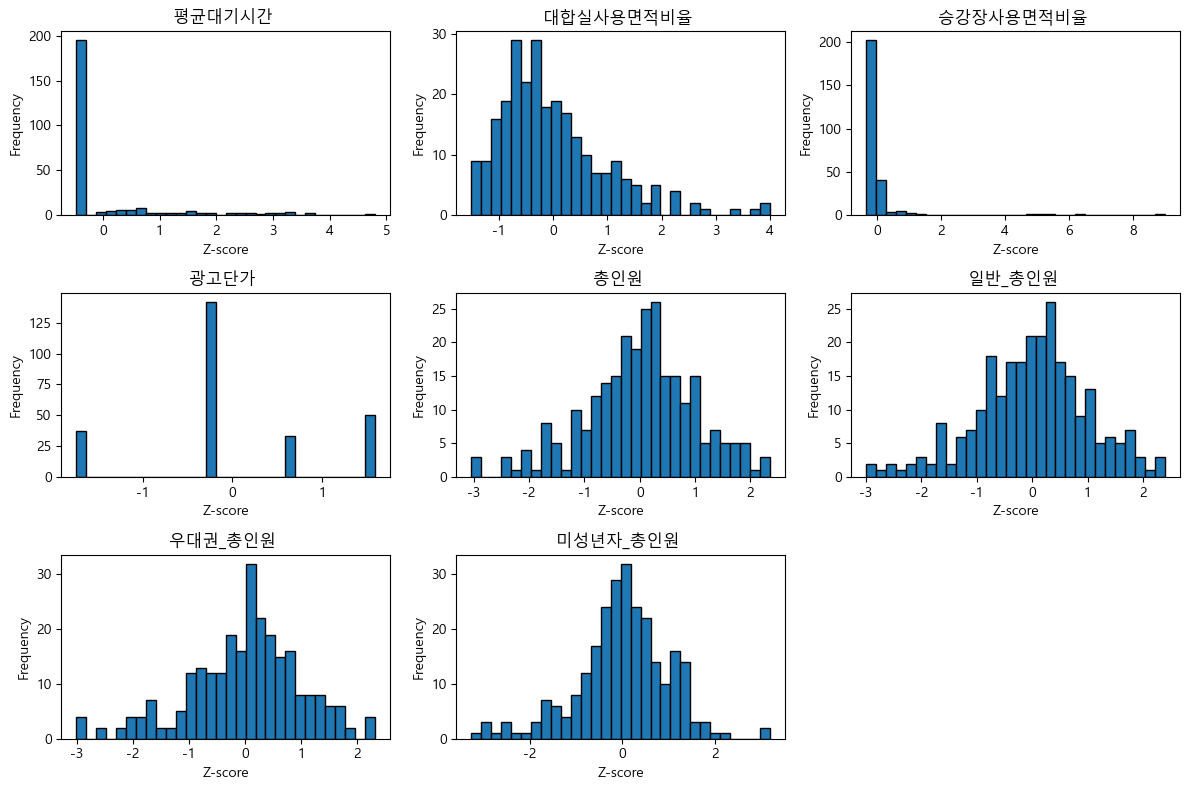


=== 평균대기시간 이상치 (9개) ===
          역명  평균대기시간
15     신당(2)  3.0786
42     대림(2)  3.2451
93     노원(4)  3.3561
107   서울역(4)  3.2451
139  종로3가(5)  3.5782
190    신당(6)  3.1341
207    노원(7)  3.2451
237    대림(7)  3.5782
258      연신내  4.7995

=== 대합실사용면적비율 이상치 (4개) ===
       역명  대합실사용면적비율
28     삼성     3.9751
31     강남     3.9974
32  교대(2)     3.4198
60     지축     3.7774

=== 승강장사용면적비율 이상치 (6개) ===
          역명  승강장사용면적비율
11     을지로입구     4.7823
12  을지로3가(2)     5.5171
23        강변     5.0940
28        삼성     9.0014
29        선릉     6.3477
31        강남     6.2322

=== 광고단가 이상치 (0개) ===
이상치 없음

=== 총인원 이상치 (2개) ===
     역명     총인원
54   신답 -3.0490
57  도림천 -3.0284

=== 일반_총인원 이상치 (0개) ===
이상치 없음

=== 우대권_총인원 이상치 (1개) ===
               역명  우대권_총인원
141  동대문역사문화공원(5)  -3.0149

=== 미성년자_총인원 이상치 (3개) ===
       역명  미성년자_총인원
25  잠실(2)    3.0466
48   홍대입구    3.2014
54     신답   -3.2746


In [16]:
# 데이터 불러오기
df_new = pd.read_csv('merged_data_2.csv', encoding='euc-kr')

# 표준화할 열 목록 (컬럼명 리스트 정의)
columns_to_scale = ['평균대기시간', '대합실사용면적비율', '승강장사용면적비율', '광고단가']

# 표준화 계산 (StandardScaler 사용)
scaler = StandardScaler()
df_new[columns_to_scale] = scaler.fit_transform(df_new[columns_to_scale])

# 소수점 4자리까지 반올림
df_new[columns_to_scale] = df_new[columns_to_scale].round(4)

# 로그 변환할 열 목록 (양수 값에만 적용)
columns_to_transform = ['총인원', '일반_총인원', '우대권_총인원', '미성년자_총인원']

# 로그 변환 (0 또는 음수는 제외)
df_new[columns_to_transform] = df_new[columns_to_transform].apply(lambda x: np.log1p(x))  # np.log1p(x) = log(x + 1)

# 표준화 계산 (StandardScaler 사용)
df_new[columns_to_transform] = scaler.fit_transform(df_new[columns_to_transform])

# 소수점 4자리까지 반올림
df_new[columns_to_transform] = df_new[columns_to_transform].round(4)

# 시각화: 표준화된 값의 히스토그램 (각각의 컬럼에 대해 Z-score의 분포)
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns_to_scale + columns_to_transform, 1):
    plt.subplot(3, 3, i)
    plt.hist(df_new[column], bins=30, edgecolor='black')
    plt.title(f'{column} ')
    plt.xlabel('Z-score')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 이상치 탐지: Z-score 기준 ±3
for col in columns_to_scale + columns_to_transform:
    z_scores = stats.zscore(df_new[col])  # Z-Score 계산
    outliers = df_new[(z_scores > 3) | (z_scores < -3)]  # Z-score가 3보다 큰 값은 이상치로 간주
    print(f"\n=== {col} 이상치 ({len(outliers)}개) ===")
    if not outliers.empty:
        print(outliers[['역명', col]])
    else:
        print("이상치 없음")

# 표준화된 데이터를 하나의 파일로 저장
df_new.to_csv('final.csv', index=False, encoding='euc-kr')

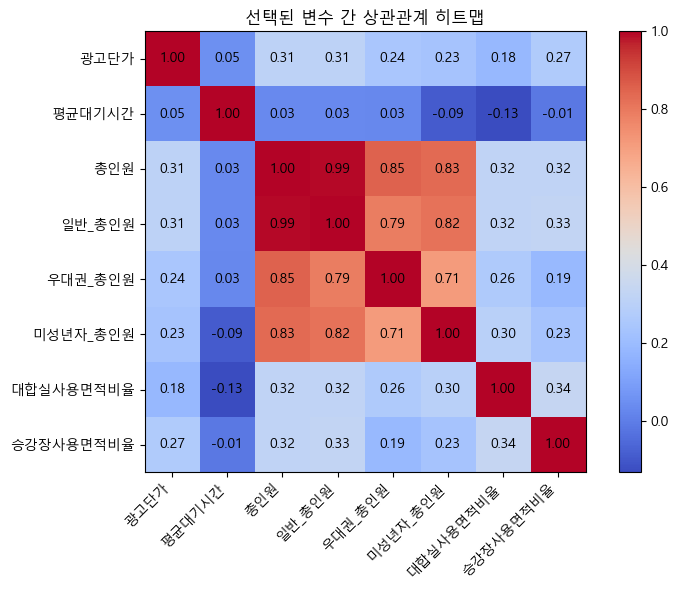

In [17]:
# CSV 파일 불러오기
df = pd.read_csv('final.csv', encoding='euc-kr')

# 사용할 열만 선택
selected_cols = ['광고단가', '평균대기시간','총인원', '일반_총인원', '우대권_총인원', '미성년자_총인원', '대합실사용면적비율', '승강장사용면적비율', ]
df_selected = df[selected_cols]

# 상관계수 계산
corr = df_selected.corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
im = plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar(im)

# 축 이름 설정
labels = corr.columns
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.yticks(range(len(labels)), labels)

# 각 셀에 상관계수 숫자 넣기
for i in range(len(corr)):
    for j in range(len(corr)):
        value = corr.iloc[i, j]
        plt.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

plt.title('선택된 변수 간 상관관계 히트맵')
plt.tight_layout()
plt.show()





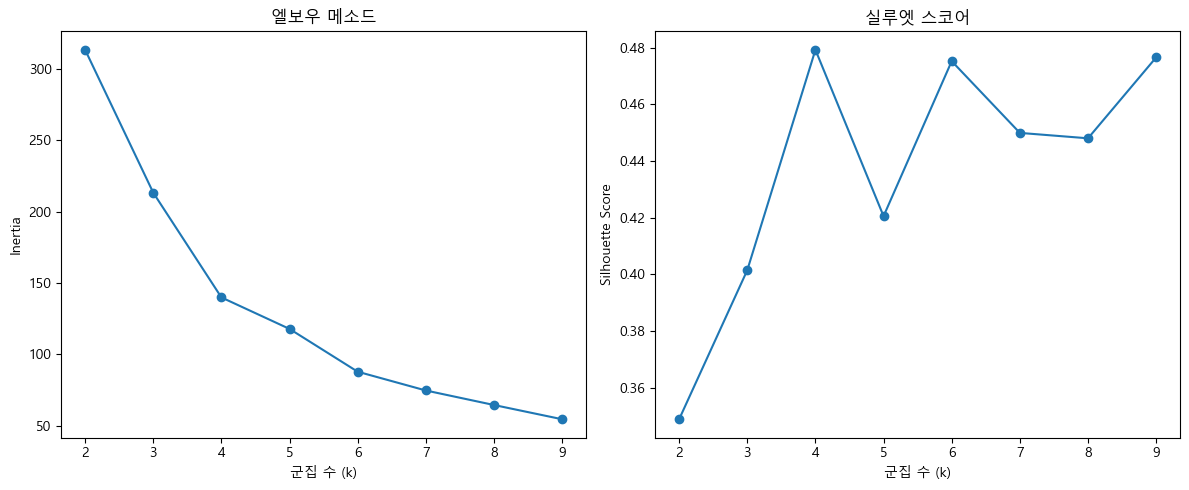

In [18]:
df = pd.read_csv('final.csv', encoding='euc-kr')

# 사용할 변수 선택
selected_cols = ['일반_총인원', '광고단가']
X_scaled = df[selected_cols].dropna()  # 이미 표준화된 데이터라고 가정

# 엘보우 & 실루엣 스코어 계산
inertias = []
silhouettes = []
ks = range(2, 10)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# 시각화
plt.figure(figsize=(12, 5))

# ▶ 엘보우 메소드
plt.subplot(1, 2, 1)
plt.plot(ks, inertias, marker='o')
plt.title('엘보우 메소드')
plt.xlabel('군집 수 (k)')
plt.ylabel('Inertia')

# ▶ 실루엣 스코어
plt.subplot(1, 2, 2)
plt.plot(ks, silhouettes, marker='o')
plt.title('실루엣 스코어')
plt.xlabel('군집 수 (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()



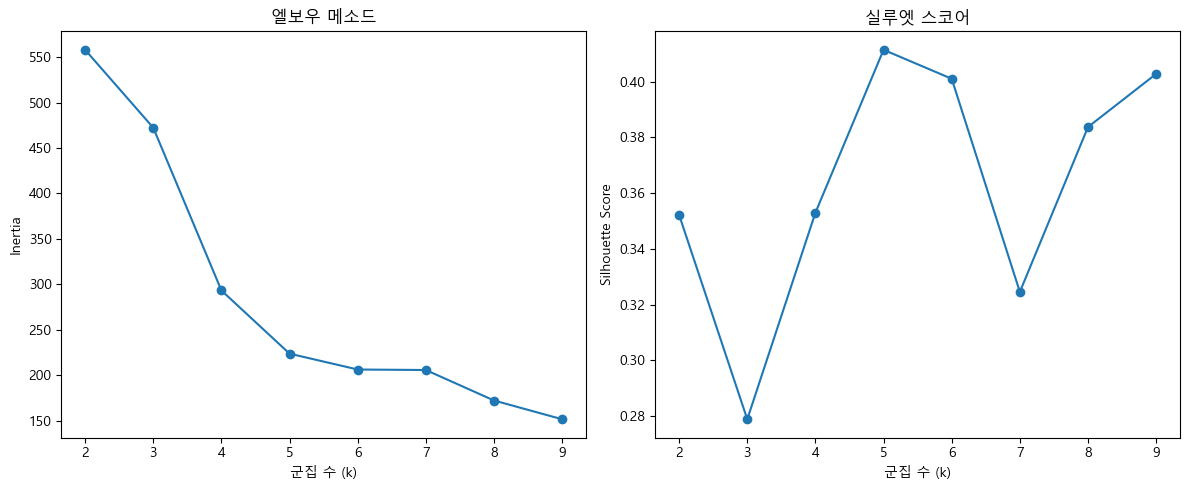

In [19]:
df = pd.read_csv('final.csv', encoding='euc-kr')

# 사용할 변수 선택
selected_cols = ['일반_총인원', '광고단가', '평균대기시간']
X_scaled = df[selected_cols].dropna()  # 이미 표준화된 데이터라고 가정

# 엘보우 & 실루엣 스코어 계산
inertias = []
silhouettes = []
ks = range(2, 10)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# 시각화
plt.figure(figsize=(12, 5))

# ▶ 엘보우 메소드
plt.subplot(1, 2, 1)
plt.plot(ks, inertias, marker='o')
plt.title('엘보우 메소드')
plt.xlabel('군집 수 (k)')
plt.ylabel('Inertia')

# ▶ 실루엣 스코어
plt.subplot(1, 2, 2)
plt.plot(ks, silhouettes, marker='o')
plt.title('실루엣 스코어')
plt.xlabel('군집 수 (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

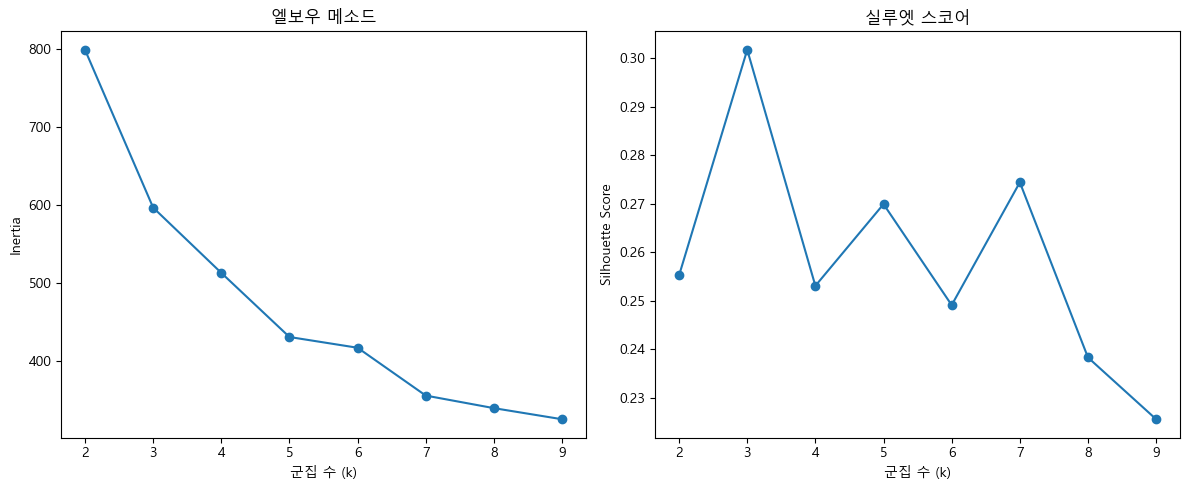

In [20]:
df = pd.read_csv('final.csv', encoding='euc-kr')

# 사용할 변수 선택
selected_cols = ['일반_총인원', '광고단가', '평균대기시간', '대합실사용면적비율']
X_scaled = df[selected_cols].dropna()  # 이미 표준화된 데이터라고 가정

# 엘보우 & 실루엣 스코어 계산
inertias = []
silhouettes = []
ks = range(2, 10)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# 시각화
plt.figure(figsize=(12, 5))

# ▶ 엘보우 메소드
plt.subplot(1, 2, 1)
plt.plot(ks, inertias, marker='o')
plt.title('엘보우 메소드')
plt.xlabel('군집 수 (k)')
plt.ylabel('Inertia')

# ▶ 실루엣 스코어
plt.subplot(1, 2, 2)
plt.plot(ks, silhouettes, marker='o')
plt.title('실루엣 스코어')
plt.xlabel('군집 수 (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [21]:
# 데이터 불러오기
df = pd.read_csv('final.csv', encoding='euc-kr')

# 사용할 변수 선택
selected_cols = ['일반_총인원', '광고단가']
X_scaled = df[selected_cols].dropna()

# KMeans 클러스터링
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# 결과 반영
df_result = df.loc[X_scaled.index].copy()
df_result['클러스터'] = labels

# 클러스터별 평균 출력
cluster_summary = df_result.groupby('클러스터')[selected_cols].mean().round(2)
print(cluster_summary)

# 불필요한 컬럼 제거 
df_result = df_result.drop(
    [ '총인원', '우대권_총인원', '미성년자_총인원', '승강장사용면적비율', '외국인비율', '장애인비율'],
    axis=1,
    errors='ignore'
)

# 저장
df_result.to_csv('final_with_cluster.csv', index=False, encoding='euc-kr')


      일반_총인원  광고단가
클러스터              
0       0.35 -0.17
1      -1.17  0.12
2       0.99  1.43
3      -0.54 -1.74


In [22]:
# 클러스터 평가 지표 계산
sil_score = silhouette_score(X_scaled, labels)
calinski = calinski_harabasz_score(X_scaled, labels)
davies = davies_bouldin_score(X_scaled, labels)

print(f" Silhouette Score: {sil_score:.4f}  (1에 가까울수록 좋음)")
print(f" Calinski-Harabasz Index: {calinski:.2f}  (클수록 좋음)")
print(f" Davies-Bouldin Index: {davies:.4f}  (작을수록 좋음)")


 Silhouette Score: 0.4792  (1에 가까울수록 좋음)
 Calinski-Harabasz Index: 236.09  (클수록 좋음)
 Davies-Bouldin Index: 0.7492  (작을수록 좋음)


📊 클러스터별 평균:
      일반_총인원  광고단가
클러스터              
0       0.35 -0.17
1      -1.17  0.12
2       0.99  1.43
3      -0.54 -1.74



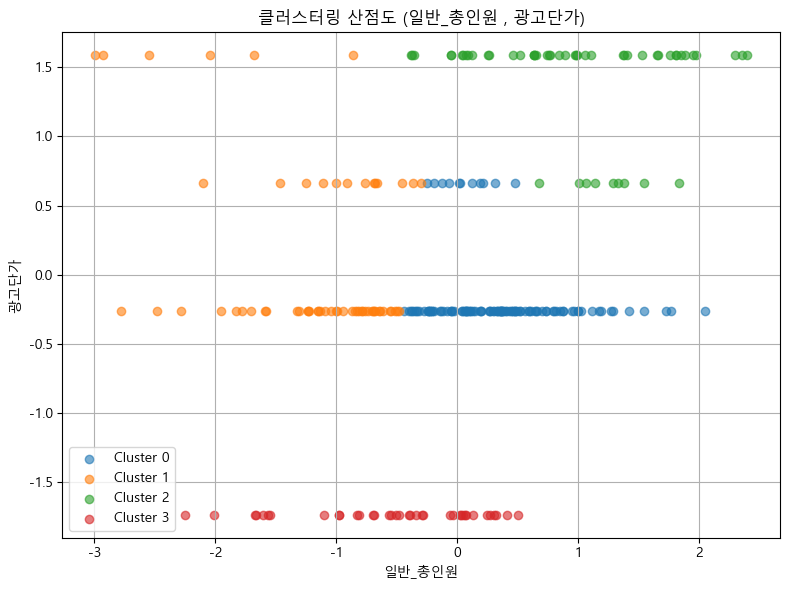

In [23]:
# 데이터 불러오기
df = pd.read_csv('final.csv', encoding='euc-kr')

# 사용할 변수 선택
features = ['일반_총인원', '광고단가']
X = df[features].dropna()

# KMeans 클러스터링 (4개 군집)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# 클러스터 결과 저장
df = df.loc[X.index].copy()
df['클러스터'] = labels

# 클러스터별 평균값 요약
cluster_summary = df.groupby('클러스터')[features].mean().round(2)
print("📊 클러스터별 평균:")
print(cluster_summary)
print()

# 산점도 시각화
plt.figure(figsize=(8, 6))
for cluster_id in sorted(df['클러스터'].unique()):
    cluster_data = df[df['클러스터'] == cluster_id]
    plt.scatter(
        cluster_data['일반_총인원'],
        cluster_data['광고단가'],
        label=f'Cluster {cluster_id}',
        alpha=0.6
    )

plt.xlabel('일반_총인원')
plt.ylabel('광고단가')
plt.title('클러스터링 산점도 (일반_총인원 , 광고단가)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


| 클러스터 | 일반\_총인원 평균 | 광고단가 평균  | 해석 요약                                |
| ---- | ------- | ----- | ------------------------------------ |
| 0    | 0.35    | -0.17 | **유동인구는 다소 많고, 광고단가는 낮음 → 가성비 좋은 역** |
| 1    | -1.17   | 0.12  | **유동인구는 적고, 광고단가는 높음 → 광고주 입장에서 비효율적, 비추천**   |
| 2    | 0.99    | 1.43  | **유동인구와 광고단가 모두 매우 높음 → 핵심 프리미엄 역**  |
| 3    | -0.54   | -1.74 | **유동인구와 광고단가 모두 낮음 → 저가 광고 전략 가능**   |



====== 클러스터 0 서브클러스터링 ======


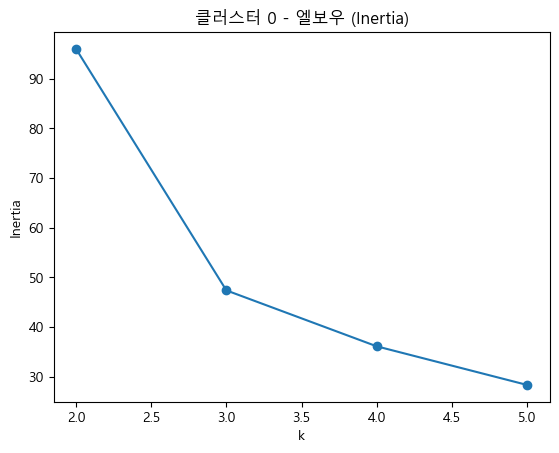

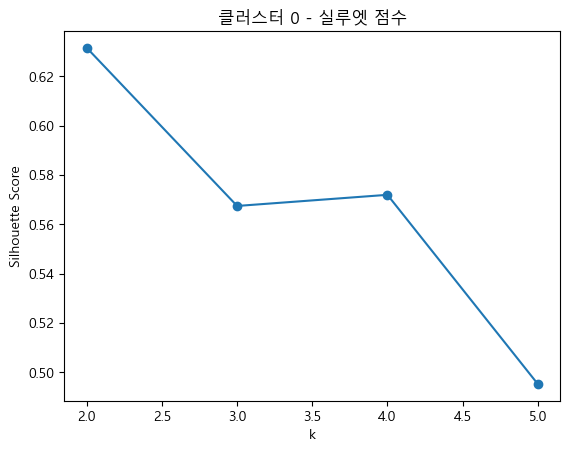

▶ 클러스터 0 서브클러스터별 평균:
        대합실사용면적비율  평균대기시간
서브클러스터                   
0          -0.363  -0.384
1          -0.238   2.454
2           1.190  -0.327

====== 클러스터 1 서브클러스터링 ======


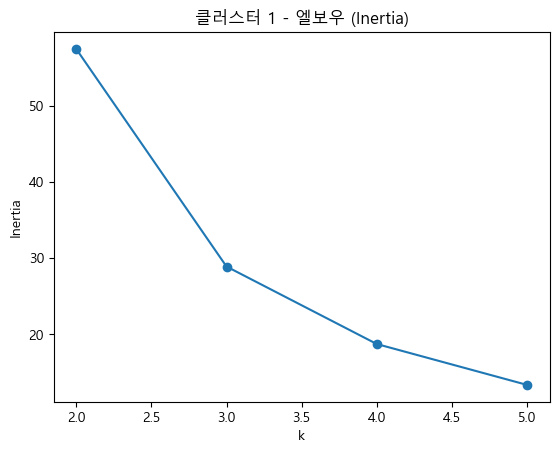

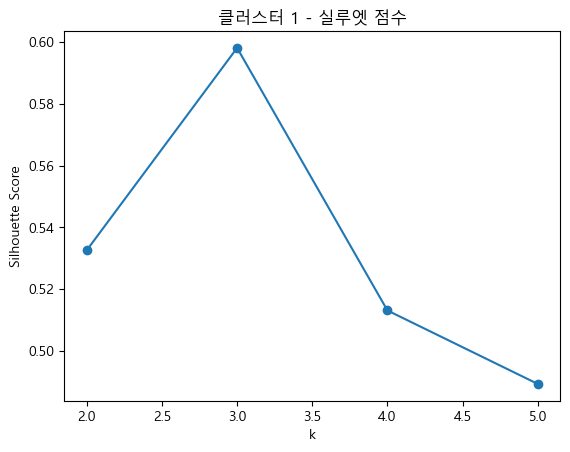

▶ 클러스터 1 서브클러스터별 평균:
        대합실사용면적비율  평균대기시간
서브클러스터                   
0          -0.788  -0.360
1           1.387  -0.424
2          -0.222   1.959

====== 클러스터 2 서브클러스터링 ======


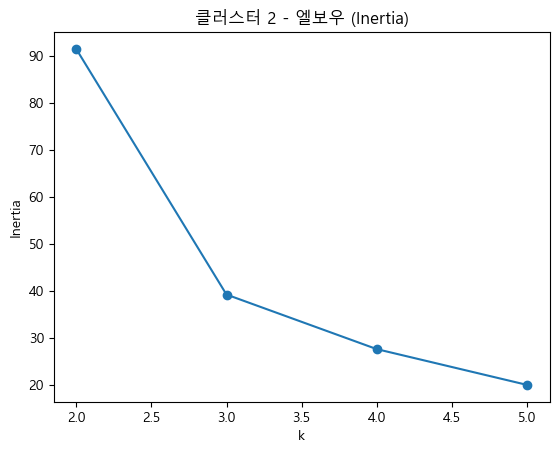

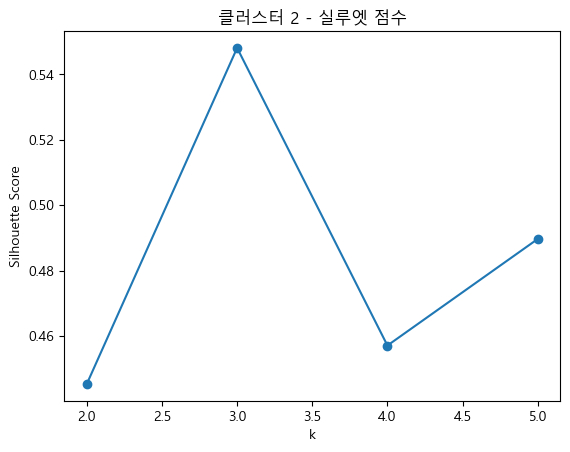

▶ 클러스터 2 서브클러스터별 평균:
        대합실사용면적비율  평균대기시간
서브클러스터                   
0           2.330  -0.308
1          -0.144  -0.243
2          -0.422   2.769

====== 클러스터 3 서브클러스터링 ======


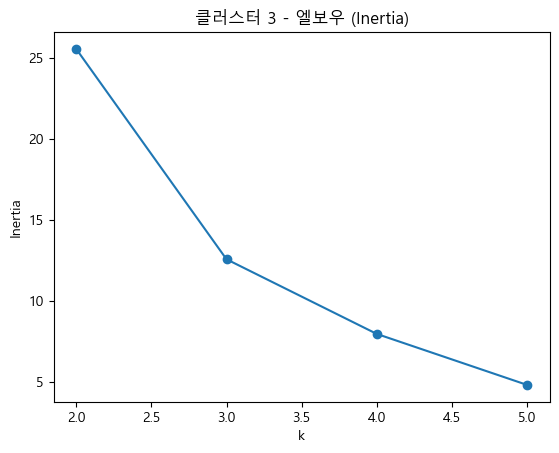

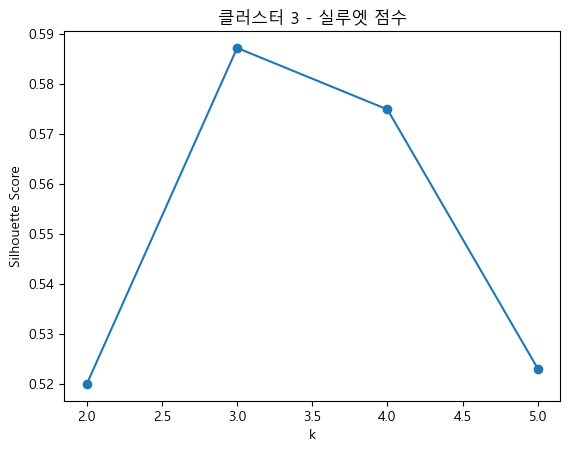

▶ 클러스터 3 서브클러스터별 평균:
        대합실사용면적비율  평균대기시간
서브클러스터                   
0          -0.360  -0.410
1          -0.433   1.350
2           1.579  -0.474


In [24]:
# 데이터 불러오기
df_all = pd.read_csv('final_with_cluster.csv', encoding='euc-kr')

# 서브클러스터링에 사용할 칼럼만 복사 (인덱스 유지)
df = df_all[['역명', '클러스터', '대합실사용면적비율', '평균대기시간']].copy()
df = df.dropna()
df['서브클러스터'] = -1  # 초기화

# 클러스터별 서브클러스터링
for cluster in sorted(df['클러스터'].unique()):
    print(f"\n====== 클러스터 {cluster} 서브클러스터링 ======")
    cluster_df = df[df['클러스터'] == cluster].copy()
    X = cluster_df[['대합실사용면적비율', '평균대기시간']]

    inertia_list = []
    silhouette_list = []
    k_range = range(2, 6)

    for k in k_range:
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = model.fit_predict(X)
        inertia_list.append(model.inertia_)
        silhouette_list.append(silhouette_score(X, labels))

    plt.figure()
    plt.plot(k_range, inertia_list, marker='o')
    plt.title(f'클러스터 {cluster} - 엘보우 (Inertia)')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.show()

    plt.figure()
    plt.plot(k_range, silhouette_list, marker='o')
    plt.title(f'클러스터 {cluster} - 실루엣 점수')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.show()

    final_model = KMeans(n_clusters=3, random_state=42, n_init=10)
    labels_final = final_model.fit_predict(X)
    df.loc[cluster_df.index, '서브클러스터'] = labels_final

    print(f"▶ 클러스터 {cluster} 서브클러스터별 평균:")
    summary = df[df['클러스터'] == cluster].groupby('서브클러스터')[['대합실사용면적비율', '평균대기시간']].mean()
    print(summary.round(3))

# 원본 데이터와 서브클러스터 병합 (역명 + 클러스터 기준)
df_all['서브클러스터'] = df['서브클러스터']  # 인덱스 기준으로 자동 정렬됨

# 저장
df_all.to_csv('final_with_subclusters.csv', index=False, encoding='euc-kr')




### 클러스터 0

| 클러스터0 서브클러스터 | 대합실사용면적비율 | 평균대기시간 |
|--------------|------------------|--------------|
| 0            | -0.363           | -0.384       |
| 1            | -0.238           |  2.454       |
| 2            |  1.190           | -0.327       |

→ 서브클러스터 1: 대기시간이 길고 공간 효율이 보통임

---

### 클러스터 1

| 클러스터1 서브클러스터 | 대합실사용면적비율 | 평균대기시간 |
|--------------|------------------|--------------|
| 0            | -0.788           | -0.360       |
| 1            |  1.387           | -0.424       |
| 2            | -0.222           |  1.959       |

→ 서브클러스터 2: 대기시간이 길고 공간 효율이 양호함

---

### 클러스터 2

| 크러스터2 서브클러스터 | 대합실사용면적비율 | 평균대기시간 |
|--------------|------------------|--------------|
| 0            |  2.330           | -0.308       |
| 1            | -0.144           | -0.243       |
| 2            | -0.422           |  2.769       |

→ 서브클러스터 2: 대기시간이 가장 길고 공간 효율도 가장 높음

---

### 클러스터 3

| 클러스터3 서브클러스터 | 대합실사용면적비율 | 평균대기시간 |
|--------------|------------------|--------------|
| 0            | -0.360           | -0.410       |
| 1            | -0.433           |  1.350       |
| 2            |  1.579           | -0.474       |

→ 서브클러스터 1: 대기시간이 길고 공간 효율이 높음



In [25]:
# 광고 효율이 높은 서브클러스터 조건 정의
target_subclusters = [
    (0, 1),
    (1, 2),
    (2, 2),
    (3, 1),
]

# 조건을 만족하는 서브클러스터 내에서 '평균대기시간 ↑ & 포화도 ↓' 기준 상위 15개 역 추출
representative_stations = []

for (cluster, sub_cluster) in target_subclusters:
    filtered = df[
        (df['클러스터'] == cluster) & 
        (df['서브클러스터'] == sub_cluster)
    ]
    
    # 두 조건을 동시에 고려한 정렬
    top_stations = filtered.sort_values(
        ['평균대기시간', '대합실사용면적비율'], 
        ascending=[False, True]
    ).head(15)
    
    for _, row in top_stations.iterrows():
        representative_stations.append({
            '클러스터': cluster,
            '서브클러스터': sub_cluster,
            '역명': row['역명'],
            '대합실사용면적비율': row['대합실사용면적비율'],
            '평균대기시간': row['평균대기시간']
        })

# 결과 확인
rep_df = pd.DataFrame(representative_stations)
print(rep_df)


    클러스터  서브클러스터            역명  대합실사용면적비율  평균대기시간
0      0       1       종로3가(5)    -0.3191  3.5782
1      0       1         대림(7)    -0.2899  3.5782
2      0       1         노원(4)     0.0569  3.3561
3      0       1        서울역(4)    -0.7659  3.2451
4      0       1         노원(7)     0.3330  3.2451
5      0       1        동대문(1)     0.8272  2.9120
6      0       1        동대문(4)     0.2522  2.8010
7      0       1         잠실(8)    -0.6517  2.5234
8      0       1        서울역(1)    -0.9648  2.4679
9      0       1        신설동(1)     0.5459  2.3013
10     0       1       종로3가(3)    -1.5030  1.7462
11     0       1      고속터미널(7)    -0.3128  1.5796
12     0       1         시청(1)    -1.1005  1.5241
13     0       1      을지로3가(3)    -0.9066  1.5241
14     0       1         약수(3)     0.9425  1.4686
15     1       2  동대문역사문화공원(5)    -0.9221  2.9120
16     1       2        충정로(5)    -0.8185  2.5234
17     1       2        삼각지(4)     0.6449  2.1903
18     1       2        신설동(2)     0.4982  1.9683


In [26]:
# 데이터 불러오기
df = pd.read_csv('final_with_cluster.csv', encoding='euc-kr')

# 필요한 컬럼만 선택
cols = ['역명', '클러스터', '대합실사용면적비율', '평균대기시간']
df = df[cols].dropna()

# 클러스터별로 기준 정하기: 면적비율은 하위 25%, 대기시간은 상위 25%
result = []

for cluster in sorted(df['클러스터'].unique()):
    sub = df[df['클러스터'] == cluster]
    
    area_threshold = sub['대합실사용면적비율'].quantile(0.15)
    wait_threshold = sub['평균대기시간'].quantile(0.85)
    
    filtered = sub[(sub['대합실사용면적비율'] <= area_threshold) & 
                   (sub['평균대기시간'] >= wait_threshold)]
    
    result.append(filtered)

# 결과 병합
final_result = pd.concat(result).sort_values(['클러스터', '평균대기시간'], ascending=[True, False])

# 결과 확인
print(final_result)


           역명  클러스터  대합실사용면적비율  평균대기시간
107    서울역(4)     0    -0.7659  3.2451
0      서울역(1)     0    -0.9648  2.4679
69    종로3가(3)     0    -1.5030  1.7462
1       시청(1)     0    -1.1005  1.5241
70   을지로3가(3)     0    -0.9066  1.5241
128  영등포구청(5)     1    -1.3781  0.4138
91      오금(3)     1    -1.4939  0.3583
140  을지로4가(5)     1    -1.3168  0.2473
258       연신내     2    -0.7691  4.7995
52     충정로(2)     2    -0.7756  2.4679
78   고속터미널(3)     2    -0.7268  2.1903
190     신당(6)     3    -0.9681  3.1341
191    동묘앞(6)     3    -0.8880  1.1910


### ✅ 고효율 조건을 모두 만족하는 핵심 중복 역 목록

| 역명             | 클러스터 | 서브클러스터 | 대합실사용면적비율 | 평균대기시간 | 클러스터 특성 요약                                |
|------------------|----------|---------------|---------------------|---------------|--------------------------------------------------|
| 서울역(4)        | 0        | 1             | -0.7659              | 3.2451        | 유동 많고 광고단가 낮음 (고효율)                |
| 서울역(1)        | 0        | 1             | -0.9648              | 2.4679        | 유동 많고 광고단가 낮음 (고효율)                |
| 종로3가(3)       | 0        | 1             | -1.5030              | 1.7462        | 유동 많고 광고단가 낮음 (고효율)                |
| 시청(1)          | 0        | 1             | -1.1005              | 1.5241        | 유동 많고 광고단가 낮음 (고효율)                |
| 을지로3가(3)      | 0        | 1             | -0.9066              | 1.5241        | 유동 많고 광고단가 낮음 (고효율)                |
| 연신내           | 2        | 2             | -0.7691              | 4.7995        | 유동 많고 광고단가 높음 (고노출 고비용)         |
| 충정로(2)        | 2        | 2             | -0.7756              | 2.4679        | 유동 많고 광고단가 높음 (고노출 고비용)         |
| 고속터미널(3)     | 2        | 2             | -0.7268              | 2.1903        | 유동 많고 광고단가 높음 (고노출 고비용)         |
| 신당(6)          | 3        | 1             | -0.9681              | 3.1341        | 유동 적고 광고단가 낮음 (저가 집중타겟 가능)    |
